## Grid analysis

Systematic examination of relationships between clinical and imaging variables

In [50]:
# Import all packages necessary
#This sets the path. Ensure you have added the path to the data to the file library/paths.py
import pool.paths as paths
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import pandas as pd
import pool.hdf5_io as hio
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
import ptitprince as pt
from statsmodels.stats import multitest


In [6]:
def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    import matplotlib
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

#This function removes lobes from analyses if they have less than a threshold number of lesions in them
#Threshold set to 10
def filter_lobes(column, threshold=10):
    """set lobes to NA if fewer cases than threshold"""
    lobes=column.value_counts().index
    counts = column.value_counts()
    for lobe, count in zip(lobes, counts):
        if count<threshold:
            column[column==lobe]=float('NaN')
            
    return column

# This function is to normalise non-normal data (either with a log transform or boxcox)
def norm_transform(df,variables,transform='log'):
    """transform continuous data"""
    for variable in variables:
        if transform =='log':
            df[variable]=np.log(np.array(df[variable])+1)
        elif transform =='boxcox':
            if np.nanmin(df[variable]) <0:
                df[variable][~df[variable].isnull()]=df[variable][~df[variable].isnull()]-np.nanmin(df[variable])+0.1
            df[variable][~df[variable].isnull()]=stats.boxcox(np.array(df[variable].dropna())+0.1)[0]
    return df

In [8]:
#runs appropriate statistical test based on the variable types.
#returns statistical value, p value, and if the p is below the threshold, plots the variables 
#against each other.
def var_test(df,var1,var2,cat1,cat2,test_to_use, stat_threshold=0.05):
    """applies appropriate test to two variables"""
    if var1 == var2:
        return 1,0,0
    df_clean=df[[var1,var2]].dropna()
    if 'Histology' in [var1,var2]:
        df_clean=df_clean[df_clean['Histology']!='NaN']
    plot=0
    if test_to_use=='chi':
        if cat1=='binary' or np.logical_and(cat1=='categorical',cat2!='binary'):
            
            contingency_table = pd.crosstab(
                df_clean[var1],
                df_clean[var2],
                margins = False
            )
        elif cat2 =='binary' or cat2 =='categorical':
            contingency_table = pd.crosstab(
                df_clean[var2],
                df_clean[var1],
                margins = False
            )
        f_obs = np.array(contingency_table)
#         f_obs = np.array([contingency_table.iloc[0].values,
#                           contingency_table.iloc[1].values])
        stat_,p= stats.chi2_contingency(f_obs)[0:2]
        if p < stat_threshold:
            plot = plot_chi(contingency_table,var1,var2, test_to_use,stat_, p)
        return stat_,p, plot
    elif test_to_use=='spearman':
        stat_,p =stats.spearmanr(df_clean)
        if p<stat_threshold: #setting x and y
            if cat1=='ranked':
                plot = plot_raincloud(df_clean,var2,var1, test_to_use,stat_, p)
            else:
                plot = plot_raincloud(df_clean,var1,var2, test_to_use,stat_, p)
        return stat_,p, plot
    elif test_to_use=='pearson':
        stat_,p = stats.pearsonr(df_clean[var1],df_clean[var2])
        if p<stat_threshold:
            plot = plot_pearson(df_clean, var1, var2, test_to_use,stat_, p)
        return stat_,p, plot
    elif test_to_use=='ttest':
        if cat1=='binary':
            gr1=list(df_clean.where(df_clean[var1]== df_clean[var1].unique()[0]).dropna()[var2])
            gr2=list(df_clean.where(df_clean[var1]== df_clean[var1].unique()[1]).dropna()[var2])
        else:
            gr1=list(df_clean.where(df_clean[var2]== df_clean[var2].unique()[0]).dropna()[var1])
            gr2=list(df_clean.where(df_clean[var2]== df_clean[var2].unique()[1]).dropna()[var1])
        stat_,p = stats.ttest_ind(gr1,gr2)   
        if p<stat_threshold :
            if  cat1=='binary':
                plot = plot_raincloud(df_clean, var2, var1, test_to_use,stat_, p)
            else:
                plot = plot_raincloud(df_clean, var1, var2, test_to_use,stat_, p)
        return stat_,p, plot        
    elif test_to_use=='anova':
        if cat1=='categorical':
            mod = ols('Q("{}") ~ Q("{}")'.format(var2,var1),
                data=df_clean).fit() 
        else:
            mod = ols('Q("{}") ~ Q("{}")'.format(var1,var2),
                data=df_clean).fit() 
        aov_table = sm.stats.anova_lm(mod, typ=2)
        print(aov_table)
        stat_=np.array(aov_table)[0,2]
        p=np.array(aov_table)[0,3]
        if p<stat_threshold:
            if cat1=='categorical':
                plot = plot_raincloud(df_clean, var2, var1, test_to_use,stat_, p)
            else:
                plot = plot_raincloud(df_clean, var1, var2, test_to_use,stat_, p)
        return stat_, p, plot
        
        
def plot_chi(contingency_table, var1, var2,test_to_use,stat_, p):
    """ plot categorical relationships with bar plots"""
    fig = plt.figure(figsize=(10,10))
    array_table=np.array(contingency_table)
    plots=[]
    running_sums=np.zeros(array_table.shape[1])
    colours=["#b0923b","#8960b3","#56ae6c","#ba495b"]
    for variable in np.arange(array_table.shape[0]):
        
        plots+=plt.bar(np.arange(array_table.shape[1]), array_table[variable,:],
                      bottom=running_sums,color=colours[variable],label=contingency_table.index[variable])
        running_sums+=array_table[variable,:]
    plt.ylabel('Number of patients')
    plt.title('{} - {}'.format(var1,var2))
    plt.xticks(np.arange(array_table.shape[1]),contingency_table.columns)

    plt.xlabel(var2)
    plt.yticks(np.arange(0, 300, 50))
    plt.legend()#plots)#plots, contingency_table.index,)
    plt.annotate( '{}\n{:.3f}\np={:.3f}'.format(test_to_use.capitalize(),stat_, p),xy=(0.05, 0.8), xycoords='axes fraction')
    return fig

def plot_raincloud(df_clean, var1, var2, test_to_use,stat_, p):
    """plot raincloud  where var1 is y and var2 is x
    For continuous vs categorical data"""
    import matplotlib
    fig = plt.figure(figsize=(10,10))
    
    if df_clean[var2].dtype==str:
        indices=np.arange(len(df_clean[var2].unique))
    else:
        indices=df_clean[var2]
    font = {'family' : 'sans',
        'weight' : 'normal',
        'size'   : 22}
    
    matplotlib.rc('font', **font)
    pt.half_violinplot(df_clean[var1],indices, bw=.2,  linewidth=1,cut=0.,\
                       scale="area", width=0.6, inner=None,orient="h")
    sns.boxplot(df_clean[var1],indices, color="black",orient="h",width=.15,zorder=10,\
                   showcaps=True,boxprops={'facecolor':'none', "zorder":10},\
                    showfliers=True,whiskerprops={'linewidth':2, "zorder":10},saturation=1)
    sns.stripplot(df_clean[var1],indices, edgecolor="white",size=3,orient="h",\
                      jitter=1,zorder=0)
    plt.title('{} - {}'.format(var2,var1),fontsize=20)
    plt.annotate('{}\n{:.3f}\np={:.3f}'.format(test_to_use.capitalize(),stat_, p),xy=(0.05, 0.9), xycoords='axes fraction',
                fontsize=15)
    plt.tight_layout()
    return fig

def plot_pearson(df_clean, var1, var2, test_to_use,stat_, p):
    """plot pearson correlation where var1 is y and var2 is x
    For two continuous variables"""
    fig = plt.figure(figsize=(10,10))
    sns.kdeplot(df_clean[var2],df_clean[var1],shade=True)
    sns.regplot(df_clean[var2],df_clean[var1],lowess=False)

    plt.title('{} - {}'.format(var2,var1))
    plt.annotate('{}\n{:.3f}\np={:.3f}'.format(test_to_use.capitalize(),stat_, p),xy=(0.05, 0.8), xycoords='axes fraction')

    return fig

def plot_chi_fractional(contingency_table, var1, var2,test_to_use,stat_, p):
    """ plot categorical relationships with bar plots"""
    fig = plt.figure(figsize=(10,10))
    array_table=np.array(contingency_table)
    plots=[]
    running_sums=np.zeros(array_table.shape[1])
    colours=["#b0923b","#8960b3","#56ae6c","#ba495b"]
    for variable in np.arange(array_table.shape[0]):
        
        plots+=plt.bar(np.arange(array_table.shape[1]), array_table[variable,:],
                      bottom=running_sums,color=colours[variable],label=contingency_table.index[variable])
        running_sums+=array_table[variable,:]
    plt.ylabel('Proportion of patients')
    plt.title('{} - {}'.format(var1,var2))
    plt.xticks(np.arange(array_table.shape[1]),contingency_table.columns)

    plt.xlabel(var2)
    plt.yticks(np.arange(0, 100, 20))
    plt.legend(loc=(1.01,.8))#plots)#plots, contingency_table.index,)
    plt.annotate( '{}\n{:.3f}\np={:.3f}'.format(test_to_use.capitalize(),stat_, p),xy=(1.02,.6), xycoords='axes fraction')
    return fig

In [9]:
#load in demographic variables for all patients
df = pd.read_csv(os.path.join(paths.data_dir,'demographics_qc.csv'))

In [14]:
# Remove any lobes with less than 20 patients' lesions
#print(np.unique(np.array(df['Lobe']).astype('str'),return_counts=True))
df['Lobe']=filter_lobes(df['Lobe'],threshold=20)
# Remove any histopathologies with less than 20 patients
#print(np.unique(np.array(df['Histology']).astype('str'),return_counts=True))
df['Histology']=filter_lobes(df['Histology'],threshold=20)

demographic_variables=list(df.columns)
demographic_variables.remove('ID')
demographic_variables.remove('Engel Outcome')
demographic_variables.remove('lesion_masked')
demographic_variables.remove('f/u')

In [15]:
#normalise features
test_variables=list(df.columns)
test_variables.remove('ID')
features_to_normalise=['Age of onset','Age at preoperative','Duration','Lesion area'] #+imaging_variables
df=norm_transform(df,features_to_normalise,
                  transform='boxcox')

/home/kwagstyl/anaconda2/envs/meld_classifier/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/kwagstyl/anaconda2/envs/meld_classifier/lib/python3.6/site-packages/ipykernel_launcher.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [16]:
#set data types for stats test
data_types={'Age at preoperative': 'continuous',
 'Age of onset': 'continuous',
 'Duration': 'continuous',
 'Seizure free': 'binary',
 'Ever reported MRI negative': 'binary',
 'Hemisphere': 'binary',
 'Lesion area': 'continuous',
 'Sex': 'binary',
 'Surgery': 'binary',
 'Lobe':'categorical',
           'Histology':'categorical'}

#chi, spearman, pearson, t test
test_types={'binary':{'binary':'chi','categorical':'chi','continuous':'ttest','ranked':'chi'},
           'categorical':{'categorical':'chi','continuous':'anova','ranked':'chi'},
           'continuous':{'continuous':'pearson','ranked':'spearman'},
           'ranked':{'ranked':'spearman'}}

In [20]:
#Calculate all the pairwise statistics and generate plots

plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = True
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False

#set up empty results matrix for stats values, p matrix for p values, test matrix for which test was used
results_matrix=np.zeros((len(demographic_variables),len(demographic_variables)))
p_results_matrix=np.zeros((len(demographic_variables),len(demographic_variables)))
tests_matrix=np.zeros((len(demographic_variables),len(demographic_variables)))

#names of the tests
test_names=['NA','chi','spearman','pearson','ttest','anova']
n_comparisons=len(demographic_variables)/(len(demographic_variables)-1)/2

#Sets the threshold for whether variable are plotted and saved
stat_threshold = 0.02
for c, var1 in enumerate(demographic_variables):
    cat1=data_types[var1]
    for r, var2 in enumerate(demographic_variables):
        if r==c:
            pass
        else:
            if 'Seizure free' in [var1,var2] and 'Surgery' in [var1,var2]:
                results_matrix[c,r],p_results_matrix[c,r]=[0,1]
                tests_matrix[c,r]=0
                continue
            
            cat2=data_types[var2]
            sorted_cat=sorted([cat1,cat2])
            test_to_use=test_types[sorted_cat[0]][sorted_cat[1]]

            results_matrix[c,r],p_results_matrix[c,r],pl=var_test(df,var1,var2, cat1,cat2,
                                                               test_to_use, stat_threshold)
            tests_matrix[c,r]=test_names.index(test_to_use)
            #print(var1,var2,p_results_matrix[c,r])

            if p_results_matrix[c,r] < stat_threshold and var1 != var2:
                #print('Significant association between : {} & {}'.format(var1,var2),test_to_use)
                pl.savefig(paths.fig_dir+"/{}-{}.png".format(var1,var2),transparent=True,bbox_inches="tight")
                plt.close(pl)

/home/kwagstyl/anaconda2/envs/meld_classifier/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/kwagstyl/anaconda2/envs/meld_classifier/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/kwagstyl/anaconda2/envs/meld_classifier/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keywo

                sum_sq     df         F    PR(>F)
Q("Lobe")    19.859397    3.0  2.953158  0.032146
Residual   1194.772931  533.0       NaN       NaN
                    sum_sq     df         F    PR(>F)
Q("Histology")    2.692359    3.0  0.462336  0.708754
Residual        712.393234  367.0       NaN       NaN


/home/kwagstyl/anaconda2/envs/meld_classifier/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/kwagstyl/anaconda2/envs/meld_classifier/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


                sum_sq     df         F    PR(>F)
Q("Lobe")    26.642383    3.0  2.287016  0.077741
Residual   2061.945487  531.0       NaN       NaN
                     sum_sq     df         F    PR(>F)
Q("Histology")    35.366149    3.0  3.083864  0.027374
Residual        1399.111766  366.0       NaN       NaN


/home/kwagstyl/anaconda2/envs/meld_classifier/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/kwagstyl/anaconda2/envs/meld_classifier/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/kwagstyl/anaconda2/envs/meld_classifier/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keywo

                sum_sq     df         F    PR(>F)
Q("Lobe")    12.969017    3.0  1.333016  0.262767
Residual   1744.747682  538.0       NaN       NaN
                     sum_sq     df         F    PR(>F)
Q("Histology")    15.706289    3.0  1.600821  0.188789
Residual        1213.342838  371.0       NaN       NaN


/home/kwagstyl/anaconda2/envs/meld_classifier/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/kwagstyl/anaconda2/envs/meld_classifier/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/kwagstyl/anaconda2/envs/meld_classifier/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit ke

                  sum_sq     df         F    PR(>F)
Q("Lobe")    9431.355919    3.0  4.233399  0.005676
Residual   403982.488534  544.0       NaN       NaN
                       sum_sq     df         F    PR(>F)
Q("Histology")    6361.753434    3.0  2.833176  0.038211
Residual        270202.423354  361.0       NaN       NaN
                sum_sq     df         F    PR(>F)
Q("Lobe")    19.859397    3.0  2.953158  0.032146
Residual   1194.772931  533.0       NaN       NaN
                sum_sq     df         F    PR(>F)
Q("Lobe")    26.642383    3.0  2.287016  0.077741
Residual   2061.945487  531.0       NaN       NaN
                sum_sq     df         F    PR(>F)
Q("Lobe")    12.969017    3.0  1.333016  0.262767
Residual   1744.747682  538.0       NaN       NaN
                  sum_sq     df         F    PR(>F)
Q("Lobe")    9431.355919    3.0  4.233399  0.005676
Residual   403982.488534  544.0       NaN       NaN


/home/kwagstyl/anaconda2/envs/meld_classifier/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/kwagstyl/anaconda2/envs/meld_classifier/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


                    sum_sq     df         F    PR(>F)
Q("Histology")    2.692359    3.0  0.462336  0.708754
Residual        712.393234  367.0       NaN       NaN
                     sum_sq     df         F    PR(>F)
Q("Histology")    35.366149    3.0  3.083864  0.027374
Residual        1399.111766  366.0       NaN       NaN
                     sum_sq     df         F    PR(>F)
Q("Histology")    15.706289    3.0  1.600821  0.188789
Residual        1213.342838  371.0       NaN       NaN
                       sum_sq     df         F    PR(>F)
Q("Histology")    6361.753434    3.0  2.833176  0.038211
Residual        270202.423354  361.0       NaN       NaN


/home/kwagstyl/anaconda2/envs/meld_classifier/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/kwagstyl/anaconda2/envs/meld_classifier/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


In [18]:
var1='Histology'
var2='Lesion area'
df_clean=df[[var1,var2]].dropna()
mod = ols('Q("{}") ~ Q("{}")'.format(var2,var1),
                data=df_clean).fit() 
aov_table = sm.stats.anova_lm(mod, typ=2)

In [22]:

# Uncomment for a closer look at particular variables


# var1='Histology'
# var2='Ever reported MRI negative'
# df_clean=df[[var1,var2]].dropna()
# if 'Histology' in [var1,var2]:
#         df_clean=df_clean[df_clean['Histology']!='NaN']
# contingency_table = pd.crosstab(
#                 df_clean[var2],
#                 df_clean[var1],
#                 margins = False
#             )

# array_table=np.array(contingency_table)

# stat_,p,dof, exp= stats.chi2_contingency(array_table)
# #fractionalise contingency table for pplotting
# for column in contingency_table.columns:
#     contingency_table[column]=100*contingency_table[column]/np.sum(contingency_table[column])

# plot=plot_chi_fractional(contingency_table,var1,var2, test_to_use,stat_, p)
# plot.savefig(paths.fig_dir+'/Proportional_{}_{}.png'.format(var1,var2),bbox_inches="tight", transparent=True)
# mc=MultiComparison(df_clean[var2],df_clean[var1])
# result = mc.tukeyhsd()
# print(result)

In [51]:
#functions for post hoc on chi squared
from statsmodels.sandbox.stats.multicomp import multipletests
from itertools import combinations


def get_asterisks_for_pval(p_val):
    """Receives the p-value and returns asterisks string."""
    if p_val > 0.05:
        p_text = "ns"  # above threshold => not significant
    elif p_val < 1e-4:  
        p_text = '****'
    elif p_val < 1e-3:
        p_text = '***'
    elif p_val < 1e-2:
        p_text = '**'
    else:
        p_text = '*'
    
    return p_text

def chisq_and_posthoc_corrected(df):
    """Receives a dataframe and performs chi2 test and then post hoc.
    Prints the p-values and corrected p-values (after FDR correction)"""
    # start by running chi2 test on the matrix
    chi2, p, dof, ex = stats.chi2_contingency(df, correction=True)
    print("Chi2 result of the contingency table: {}, p-value: {}".format(chi2,p))
    
    # post-hoc
    all_combinations = list(combinations(df.index, 2))  # gathering all combinations for post-hoc chi2
    p_vals = []
    print("Significance results:")
    for comb in all_combinations:
        new_df = df[(df.index == comb[0]) | (df.index == comb[1])]
        chi2, p, dof, ex = stats.chi2_contingency(new_df, correction=True)
        p_vals.append(p)
        # print(f"For {comb}: {p}")  # uncorrected

    # checking significance
    # correction for multiple testing
    reject_list, corrected_p_vals = multipletests(p_vals, method='fdr_bh')[:2]
    for p_val, corr_p_val, reject, comb in zip(p_vals, corrected_p_vals, reject_list, all_combinations):
        print("{}: p_value: {:5f}; corrected: {:5f} ({}) reject: {}".format(
        comb,p_val,corr_p_val,get_asterisks_for_pval(p_val),reject))
        
        
        
        

In [52]:
# Chi square test to establish which histology subtypes are signficantly 
# differently located across cortical lobes
# print(contingency_table)
# chisq_and_posthoc_corrected(contingency_table)
# mc=MultiComparison(df_clean[var2],df_clean[var1])
# result = mc.tukeyhsd()

In [56]:
# Correct for multiple comparisons

sorted_p=[]
indices=[]
corrected=np.ones_like(p_results_matrix)
for k in range(len(p_results_matrix)):
    for p in range(len(p_results_matrix)-k-1):
        sorted_p.append(p_results_matrix[p,k])
        indices.append([p,k])
indices=np.array(indices)
mask=np.ones_like(p_results_matrix).astype(bool)
mask[np.triu_indices(np.shape(p_results_matrix)[0])]=0

threshold=multitest.multipletests(p_results_matrix[mask],method='fdr_bh')
#corrected[indices[threshold]]=0
#plt.matshow(p_results_matrix)
corrected[mask]=~threshold[0]
#plt.matshow(1-corrected)

In [57]:
#corrected=p_results_matrix>0.01

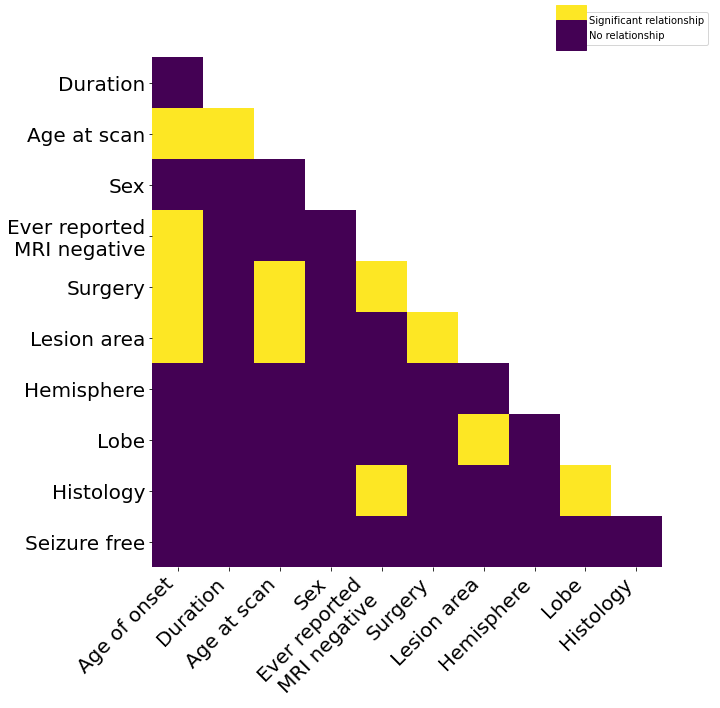

In [58]:
# Plot grid of interrelationships that remain signficant after correction for multiple comparisons
#create mask for diagonal matrix
mask=np.zeros_like(p_results_matrix)
mask[np.triu_indices(np.shape(p_results_matrix)[0])]=1

# Removes axes for the grid plot below
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
from matplotlib import cm as cm
#set figure size and create plot
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)

#skew colourmap as we are only interested in the lower p values.
cmap = cm.get_cmap('viridis')
shifted=shiftedColorMap(cmap,start=1,midpoint=0.001, stop=0)

#set all p values above to 1, so all non-significant.
#p_results_matrix[p_results_matrix>0.05]=1
corrected=np.ma.masked_where(mask,corrected)

#plot grid of pvalues
cax = ax1.imshow(corrected,  cmap=shifted)

labels=[]
for label in demographic_variables:
    if label=='Age at preoperative':
        labels.append('Age at scan')
    elif 'Ever reported' in label:
        labels.append('Ever reported\nMRI negative')
    else:
        labels.append(label)
#set xtick 
#ax1.set_ylim(len(demographic_variables)-1,-0.5)
#ax1.set_xlim(-0.5,len(demographic_variables)-1)

ax1.set_yticks(np.arange(len(demographic_variables)-1)+1)
ax1.set_yticklabels(labels[1:],fontsize=20)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.xaxis.set_ticks_position("bottom")
ax1.set_xticks(np.arange(len(demographic_variables)-1))
ax1.set_xticklabels(labels[:-1],fontsize=20,rotation=45,horizontalalignment='right')
#create colourbar for pvalues
# cbar=fig.colorbar(cax, fraction=0.035)
# cbar.ax.set_title('p values',size=25,loc='left', pad=20)
# cbar.ax.tick_params(labelsize=20)
legs=[]
legs+=ax1.plot([],[],'s',ms=30,color=shifted(0))
legs+=ax1.plot([],[],'s',ms=30,color=shifted(255))

ax1.legend(legs,['Significant relationship','No relationship'],loc='best')
fig.tight_layout()
fig.savefig(os.path.join(paths.fig_dir,'grid_results.pdf'), bbox_inches="tight",transparent=True)


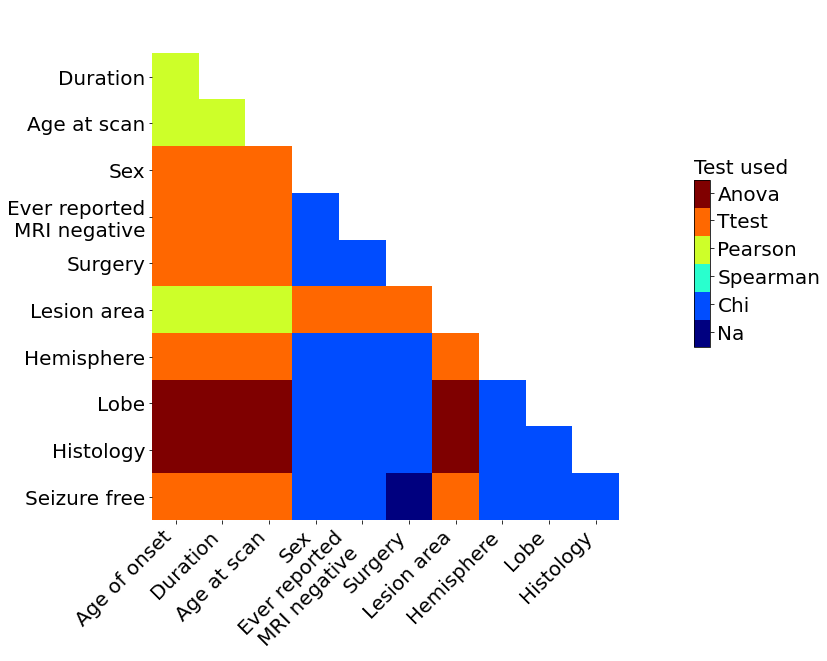

In [59]:
# Plot grid of statistical tests used
from matplotlib import cm as cm
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True


fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
cmap = cm.get_cmap('jet', len(test_names))
##TODO add key
#fig.legend(test_names)
tests_matrix=np.ma.masked_where(mask,tests_matrix)

plt.imshow(tests_matrix,  cmap=cmap)
test_names=[v.capitalize() for v in test_names]

ax1.set_yticks(np.arange(len(demographic_variables)-1)+1)
ax1.set_yticklabels(labels[1:],fontsize=20)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.xaxis.set_ticks_position("bottom")
ax1.set_xticks(np.arange(len(demographic_variables)-1))
ax1.set_xticklabels(labels[:-1],fontsize=20,rotation=45,horizontalalignment='right')

cbar=plt.colorbar(fraction=0.03, aspect = 10)
cbar.set_ticks(np.linspace(0.45,len(test_names)-0.55,len(test_names)+1))
cbar.set_ticklabels(test_names)
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_title('Test used', size=20, loc='left')
fig.savefig(os.path.join(paths.fig_dir,'grid_tests.pdf'), bbox_inches="tight",transparent=True)

In [60]:
# var1='Histology'
# var2='Lesion area'
# df_clean=df[[var1,var2]].dropna()



# mod = ols('Q("{}") ~ Q("{}")'.format(var2,var1),data=df_clean).fit() 
# aov_table = sm.stats.anova_lm(mod, typ=2)
# mc=MultiComparison(df_clean[var2],df_clean[var1])
# result = mc.tukeyhsd()
# stat_=np.array(aov_table)[0,2]
# p=np.array(aov_table)[0,3]
# plot_raincloud(df_clean, var2, var1, test_to_use,stat_, p)
# print(result,p)

/home/kwagstyl/anaconda2/envs/meld_classifier/lib/python3.6/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()
/home/kwagstyl/anaconda2/envs/meld_classifier/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


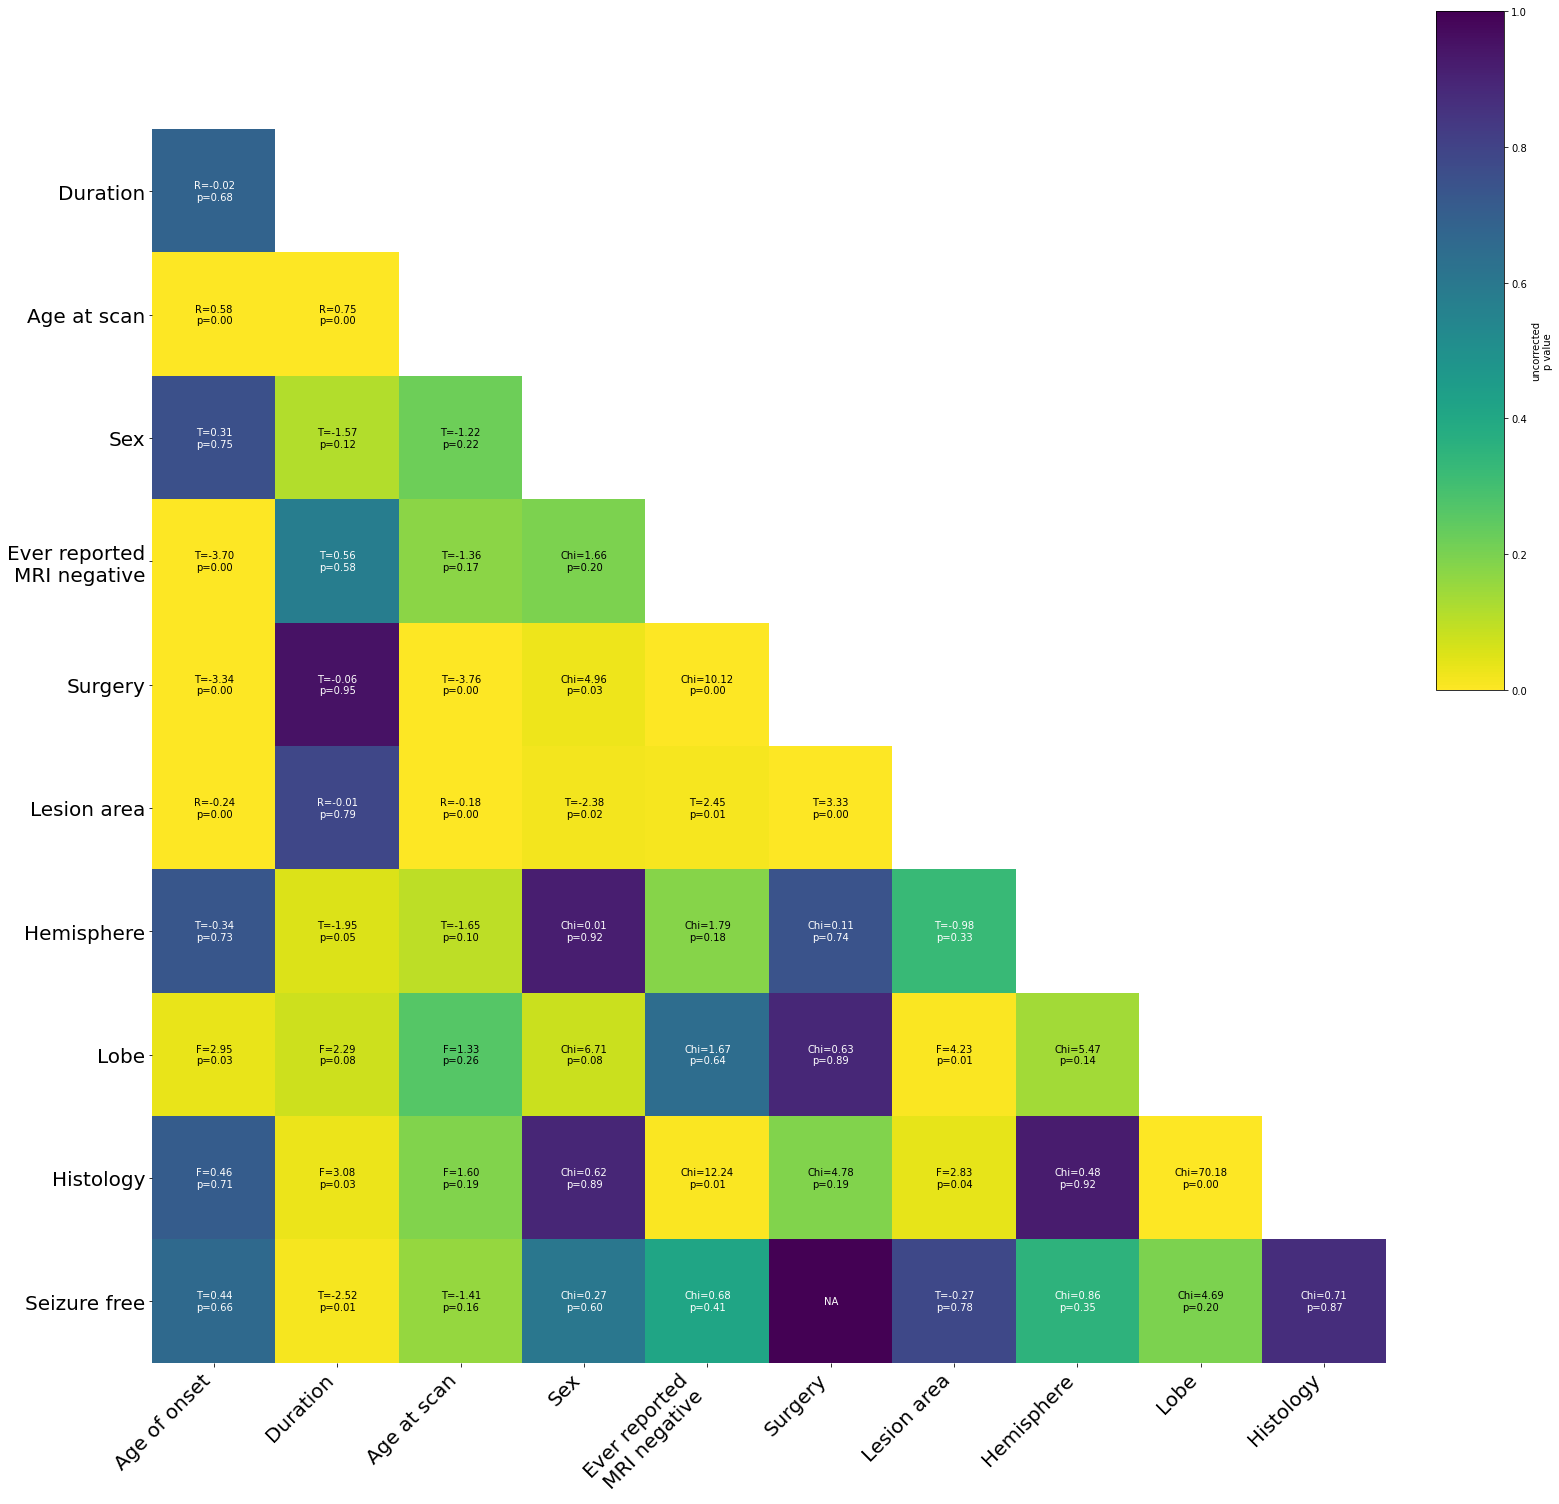

In [61]:
# Plot grid of interrelationships that remain signficant after correction for multiple comparisons
#create mask for diagonal matrix
mask=np.zeros_like(p_results_matrix)
mask[np.triu_indices(np.shape(p_results_matrix)[0])]=1

# Removes axes for the grid plot below
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
from matplotlib import cm as cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

#set figure size and create plot
fig = plt.figure(figsize=(21,21))
ax = plt.gca()

ax1 = fig.add_subplot(111)

#skew colourmap as we are only interested in the lower p values.
cmap = cm.get_cmap('viridis')
shifted=shiftedColorMap(cmap,start=1,midpoint=0.05, stop=0)

#set all p values above to 1, so all non-significant.
#p_results_matrix[p_results_matrix>0.05]=1
corrected=np.ma.masked_where(mask,p_results_matrix)

#plot grid of pvalues
cax = ax1.imshow(corrected,  cmap='viridis_r')


#set xtick 
#ax1.set_ylim(len(demographic_variables)-1,-0.5)
#ax1.set_xlim(-0.5,len(demographic_variables)-1)
test_stats=['NA','Chi','R','R','T','F']
ax1.set_yticks(np.arange(len(demographic_variables)-1)+1)
ax1.set_yticklabels(labels[1:],fontsize=20)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.xaxis.set_ticks_position("bottom")
ax1.set_xticks(np.arange(len(demographic_variables)-1))
ax1.set_xticklabels(labels[:-1],fontsize=20,rotation=45,horizontalalignment='right')
#create colourbar for pvalues
# cbar=fig.colorbar(cax, fraction=0.035)
# cbar.ax.set_title('p values',size=25,loc='left', pad=20)
# cbar.ax.tick_params(labelsize=20)

#ax1.legend(legs,['Significant relationship','No relationship'],loc='best')
axins1 = inset_axes(ax1,
                    width="5%",  # width = 50% of parent_bbox width
                    height="50%",  # height : 5%
                    )

plt.colorbar(cax, cax=axins1, label='uncorrected\np value',
            )

kw = dict(horizontalalignment="center",
              verticalalignment="center")
def tf(**textkw):
    return textkw
textkw=tf()
kw.update(textkw)
textcolors=("black", "white")
threshold=0.3
texts=[]
for i in range(results_matrix.shape[0]):
        for j in range(results_matrix.shape[1]):
            
            if i>j:
                kw.update(color=textcolors[int(cax.norm(p_results_matrix[i, j]) > threshold)])
                if test_stats[int(tests_matrix[i,j])]=='NA':
                    text = cax.axes.text(j, i,'NA',**kw)
                else:
                    text = cax.axes.text(j, i, '{}={:.2f}\np={:.2f}'.format(test_stats[int(tests_matrix[i,j])],
                                                                               results_matrix[i, j],
                                                                   p_results_matrix[i, j]), **kw)
                texts.append(text)
            
fig.tight_layout()
fig.savefig(os.path.join(paths.fig_dir,'grid_results_uncorr.pdf'), bbox_inches="tight",transparent=True)
